In [29]:
import pandas as pd
import joblib, json
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

# paths
DATA = Path("../data/processed")
MODEL_DIR = Path("../models")

# load data
df = pd.read_csv(DATA / "report_features.csv", parse_dates=["receivedate"])
TARGET = "is_serious_report"
X = df.drop(columns=[TARGET, "safetyreportid", "receivedate"])
y = df[TARGET]

# train-test split (same as before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# reload models
logreg = joblib.load(MODEL_DIR / "logreg_baseline.joblib")
rf = joblib.load(MODEL_DIR / "rf_model.joblib")
gb = joblib.load(MODEL_DIR / "gb_model.joblib")

print("Models & data ready.")

Models & data ready.


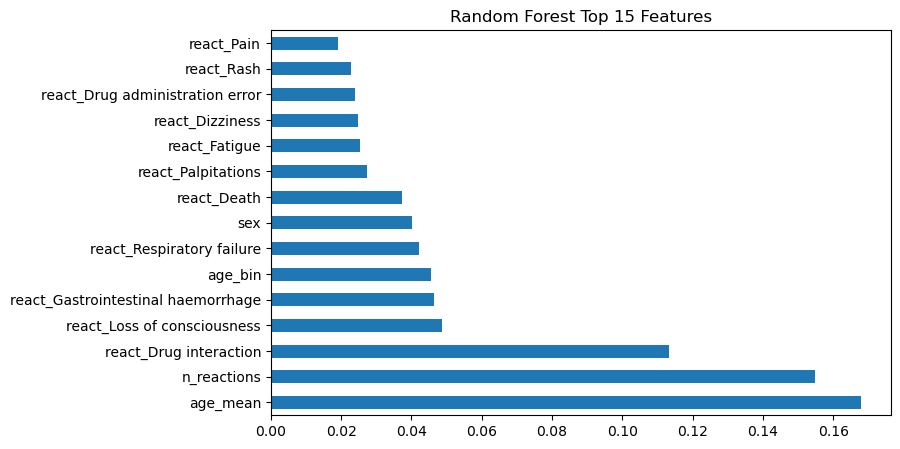

In [30]:
import matplotlib.pyplot as plt

rf_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
rf_imp.head(15).plot(kind="barh")
plt.title("Random Forest Top 15 Features")
plt.show()


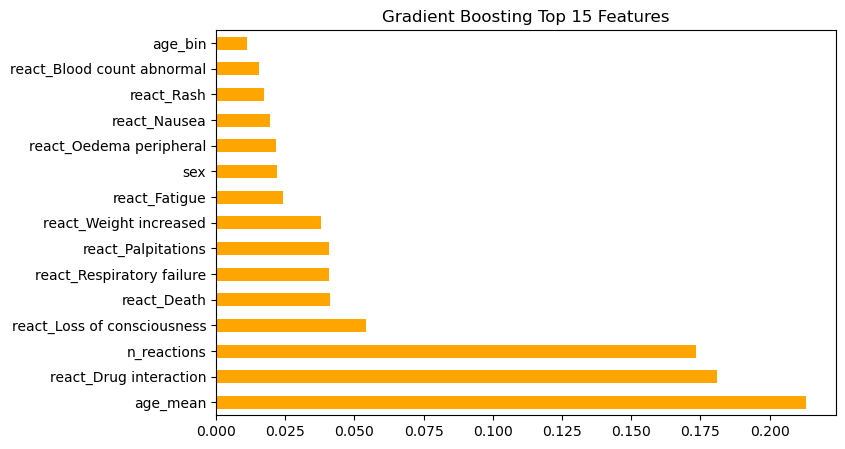

In [31]:
gb_imp = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
gb_imp.head(15).plot(kind="barh", color="orange")
plt.title("Gradient Boosting Top 15 Features")
plt.show()


X_test_aligned dtypes:
int64      35
float64     2
bool        1
Name: count, dtype: int64

X_test_clean dtypes:
int64      33
float64     2
bool        1
Name: count, dtype: int64


/var/folders/0l/6vyd7t0s5n36rmvwf6jq4jw00000gn/T/ipykernel_2922/3064568351.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')


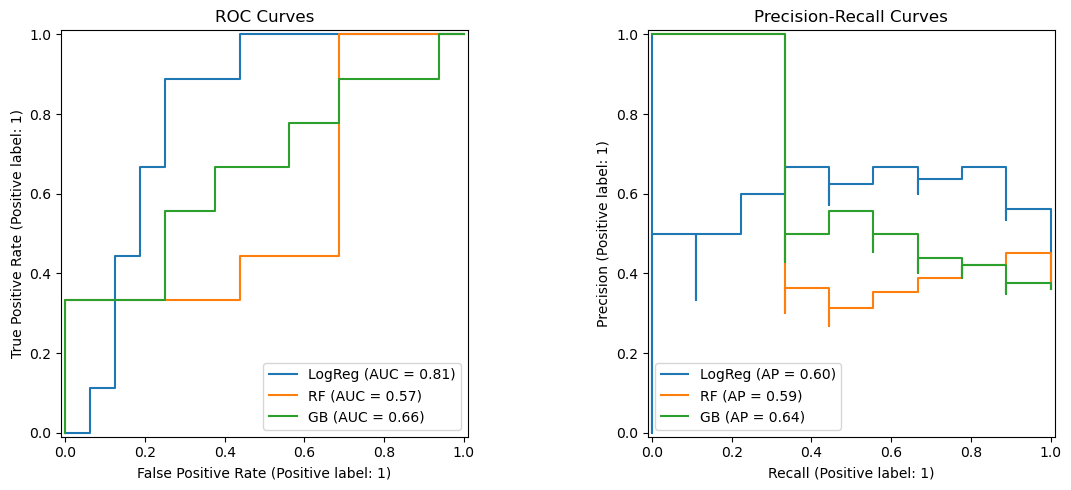

In [32]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import pandas as pd
import numpy as np

# Create a function to convert categorical variables to numeric
def convert_categorical_to_numeric(df):
    df_clean = df.copy()
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            # Try to convert to numeric first (for ordinal categories)
            df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')
            
            # If still object type, use label encoding
            if df_clean[col].dtype == 'object':
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                # Handle NaN values and convert to string for encoding
                df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    # Fill any remaining NaN values
    df_clean = df_clean.fillna(0)
    return df_clean

# Clean both datasets
X_test_clean = convert_categorical_to_numeric(X_test)

# For Logistic Regression, we still need to align features
X_test_aligned = X_test_clean.copy()

# Add missing columns with 0 values
for feature in logreg.feature_names_in_:
    if feature not in X_test_aligned.columns:
        X_test_aligned[feature] = 0

# Remove extra columns and ensure correct order
X_test_aligned = X_test_aligned[logreg.feature_names_in_]

# Fill any NaN values
X_test_aligned = X_test_aligned.fillna(0)
X_test_clean = X_test_clean.fillna(0)

# Verify all data is numeric
print("X_test_aligned dtypes:")
print(X_test_aligned.dtypes.value_counts())
print("\nX_test_clean dtypes:")
print(X_test_clean.dtypes.value_counts())

# Now run your evaluation code
plt.figure(figsize=(12,5))

# ROC curves
plt.subplot(1,2,1)
for name, model in models.items():
    if name == "LogReg":
        preds = model.predict_proba(X_test_aligned)[:,1]
    else:
        preds = model.predict_proba(X_test_clean)[:,1]
    RocCurveDisplay.from_predictions(y_test, preds, name=name, ax=plt.gca())
plt.title("ROC Curves")

# PR curves
plt.subplot(1,2,2)
for name, model in models.items():
    if name == "LogReg":
        preds = model.predict_proba(X_test_aligned)[:,1]
    else:
        preds = model.predict_proba(X_test_clean)[:,1]
    PrecisionRecallDisplay.from_predictions(y_test, preds, name=name, ax=plt.gca())
plt.title("Precision-Recall Curves")

plt.tight_layout()
plt.show()